In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
from classical_approach import *
import numpy as np
import jax
import matplotlib.pyplot as plt
import seaborn as sns
root_path = Path().resolve().parents[1]
data_path = root_path / "data"
halos_path = data_path / "halos.pkl"
rng = jax.random.PRNGKey(0)

In [12]:
with open(halos_path, "rb") as f:
    particles, halo_slice  = pickle.load(f)

train_indices = np.loadtxt(data_path / "train_indices.txt").astype(int)

In [31]:
halo_slice.keys()

dict_keys(['GroupMass', 'GroupMassType', 'GroupLenType', 'Group_R_Mean200', 'Group_M_Mean200', 'GroupFirstSub', 'GroupID', 'GroupStellarMass', 'SubhaloSpin', 'SubhaloVmax'])

In [66]:
train_masses = halo_slice["GroupMass"][train_indices]
train_log_points = jnp.array([np.log(particles[train_index]['count']) for train_index in train_indices])
train_star_masses = jnp.log10(
        halo_slice["GroupStellarMass"] * 1e10 / 0.677
    )[train_indices]

sample: 100%|██████████| 5000/5000 [00:03<00:00, 1286.36it/s, 7 steps of size 7.00e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      9.54      0.03      9.54      9.48      9.59   3475.83      1.00
  slopes[0]     -0.01      0.03     -0.01     -0.07      0.04   3384.52      1.00
        std      0.22      0.02      0.22      0.19      0.26   3467.13      1.00

Number of divergences: 0


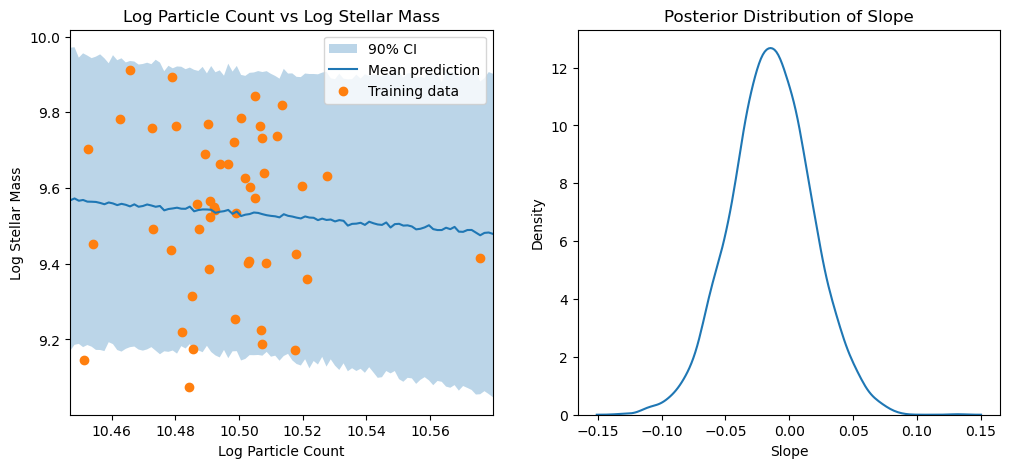

In [84]:
def regress_and_plot(predictor, predictor_name, target, target_name):
    center = np.mean(predictor)
    scale = np.std(predictor)
    predictor_transformed = (predictor - center) / scale


    nuts_kernel = NUTS(linear_regression)
    mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=1)
    mcmc.run(rng, predictor_transformed.reshape(-1, 1), target)
    samples = mcmc.get_samples()
    mcmc.print_summary()

    predictive_distribution = Predictive(linear_regression, samples)
    sample_points = jnp.linspace(predictor_transformed.min() - 0.2, predictor_transformed.max() + 0.2, 100)
    predictive_samples = predictive_distribution(rng, sample_points.reshape(-1, 1))


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].fill_between((sample_points * scale) + center, *jnp.percentile(predictive_samples["predictions"], jnp.array([5, 95]), axis=0), alpha=0.3, label="90% CI")
    axs[0].plot((sample_points * scale) + center, jnp.mean(predictive_samples["predictions"], axis=0), label="Mean prediction")
    axs[0].scatter(predictor, target, color="C1", label="Training data")
    axs[0].set(xlim = (sample_points.min() * scale + center, sample_points.max() * scale + center), ylabel=target_name, xlabel=predictor_name, title=f"{predictor_name} vs {target_name}")
    axs[0].legend()

    sns.kdeplot(samples["slopes"].flatten(), ax=axs[1])
    axs[1].set(title="Posterior Distribution of Slope", xlabel="Slope")

predictor = train_log_points
predictor_name = "Log Particle Count"
target = train_star_masses
target_name = "Log Stellar Mass"

regress_and_plot(predictor, predictor_name, target, target_name)

sample: 100%|██████████| 5000/5000 [00:03<00:00, 1349.01it/s, 3 steps of size 8.52e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      9.54      0.03      9.54      9.49      9.59   3336.86      1.00
  slopes[0]     -0.04      0.03     -0.04     -0.09      0.01   4648.26      1.00
        std      0.22      0.02      0.22      0.18      0.26   3744.12      1.00

Number of divergences: 0


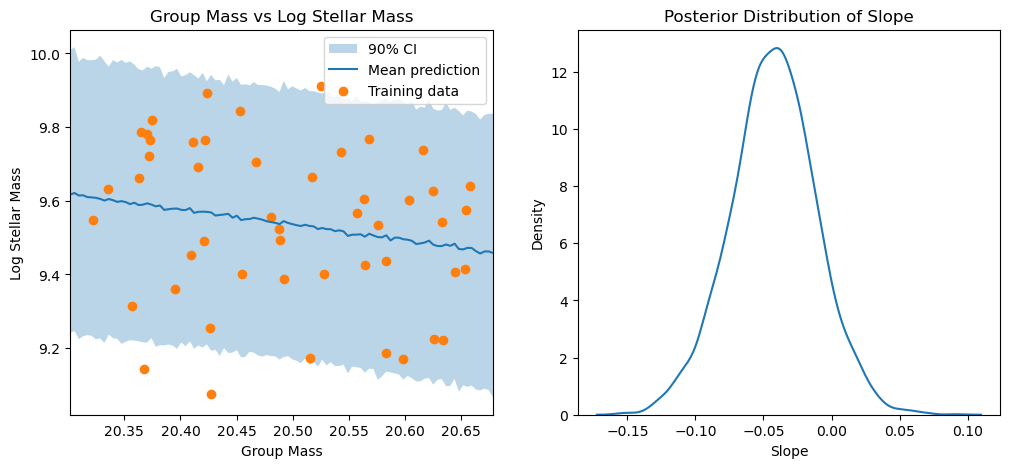

In [85]:
predictor = train_masses
predictor_name = "Group Mass"
target = train_star_masses
target_name = "Log Stellar Mass"

regress_and_plot(predictor, predictor_name, target, target_name)